# 成功しているかどうかでEDAする 2
前スレ: `is_success.ipynb`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import plotly.express as px
import plotly.io as pio

from transforms.dataframes.is_success import dataframe_is_success
from transforms.dataframes.preprocess import dataframe_preprocess

pio.renderers.default = "notebook_connected"


In [2]:
DATA = dataframe_is_success(dataframe_preprocess(pd.read_csv("data/kickstarter.csv")))
DATA.columns

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Index(['ID', 'name', 'main_category', 'sub_category', 'country', 'currency',
       'launched', 'deadline', 'goal', 'pledged', 'backers',
       'usd_pledged_real', 'usd_goal_real', 'is_success'],
      dtype='object')

## 国別で差があるのだろうか
あまりあってほしくないけど

                                             |          | [  0%]   00:00 -> (? left)


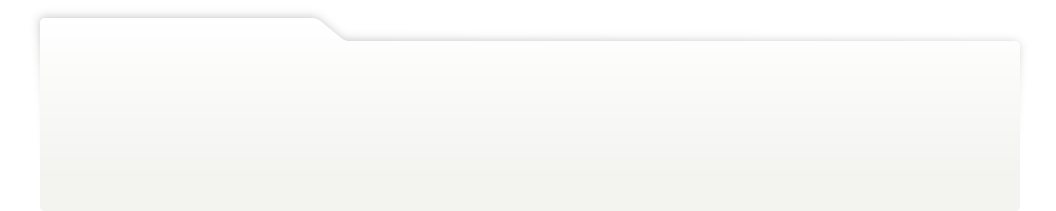
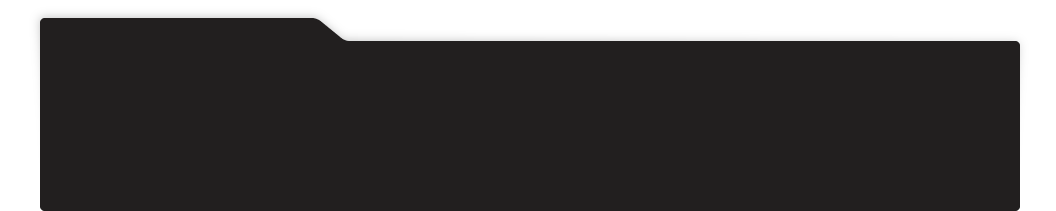
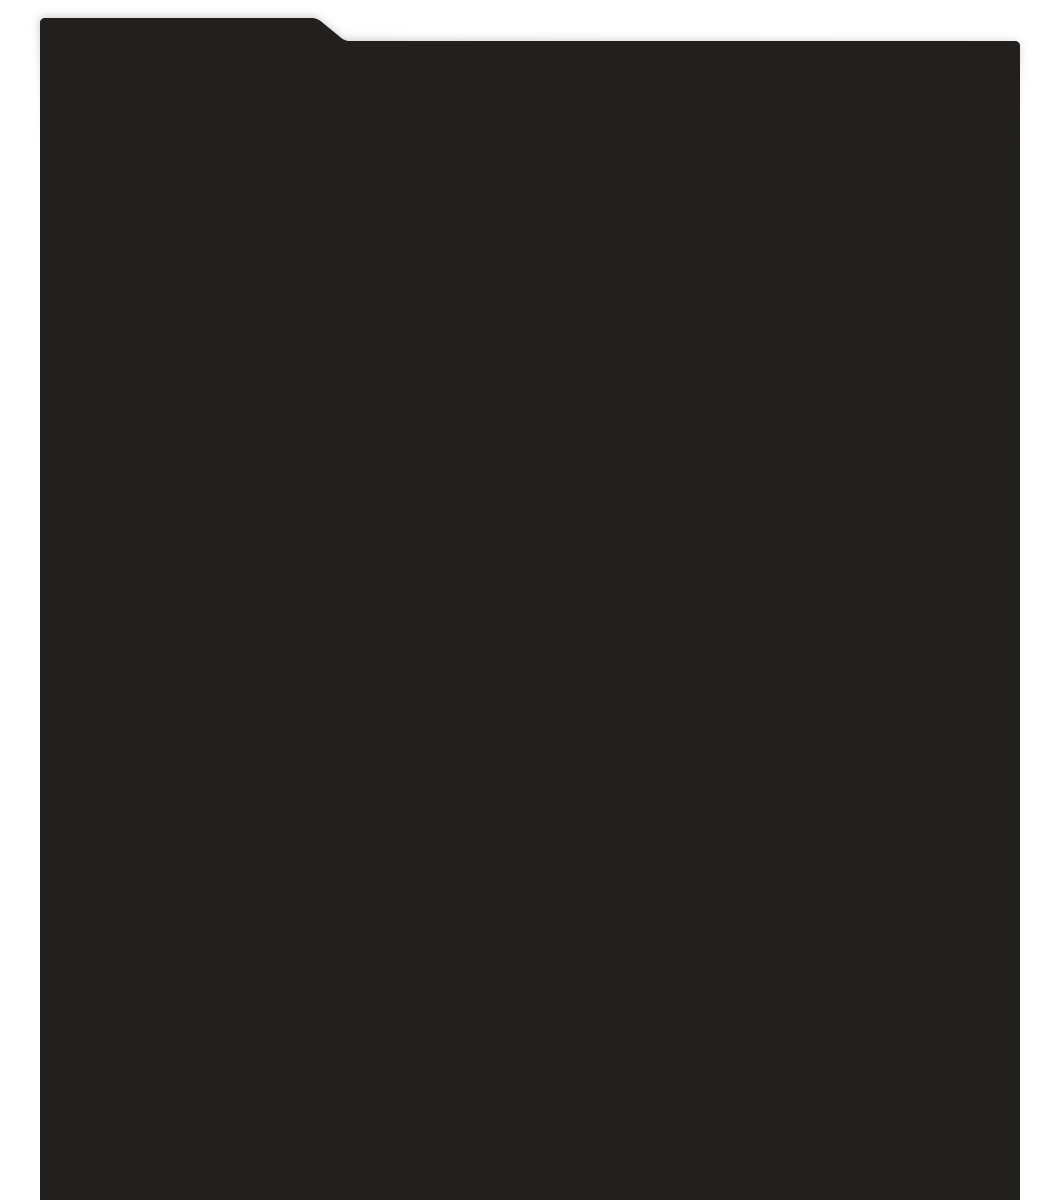
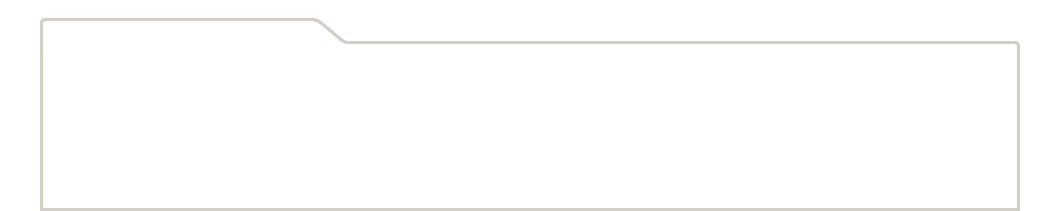
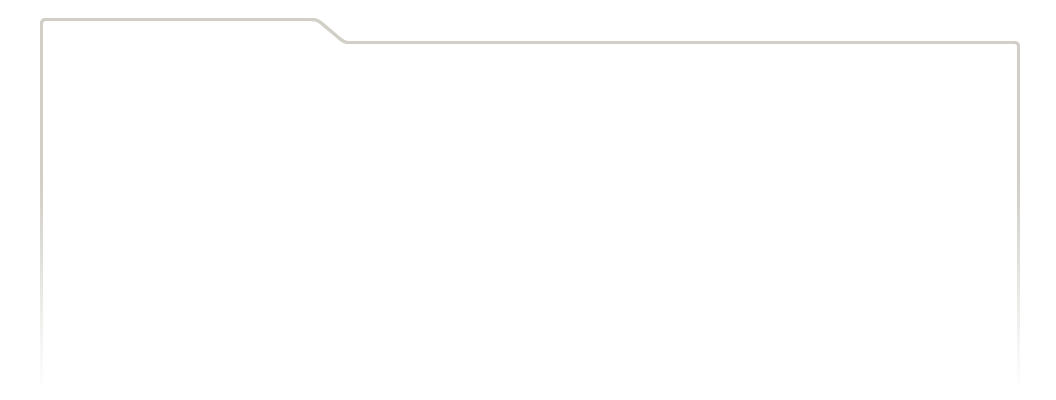
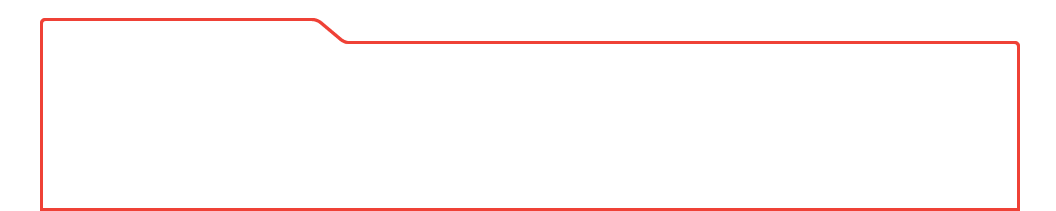
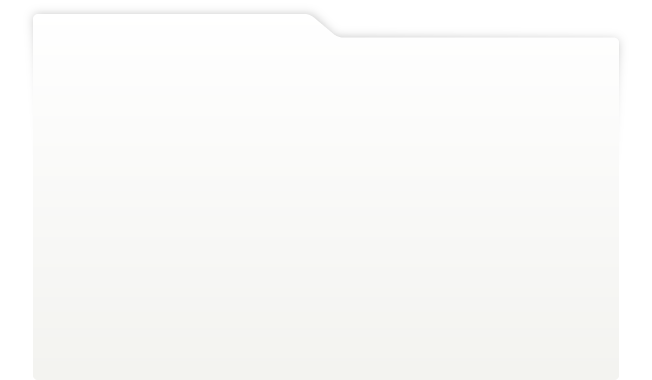
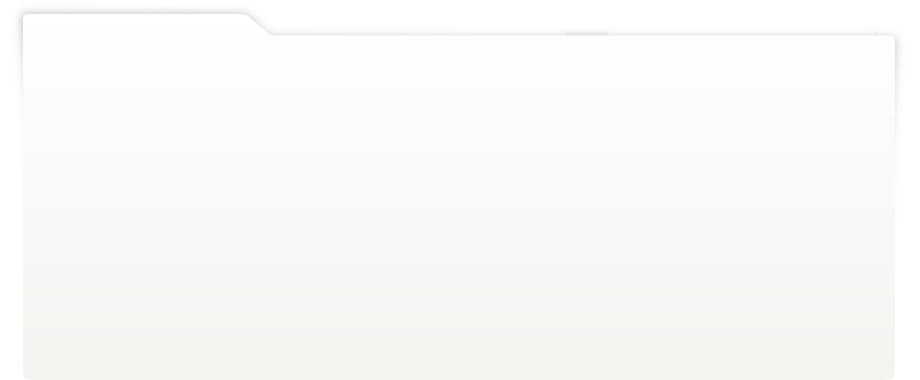
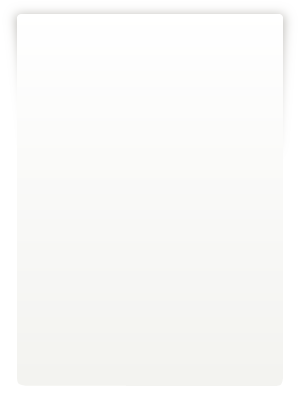
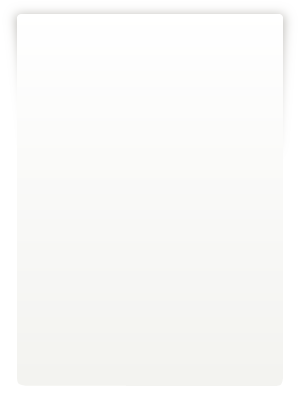
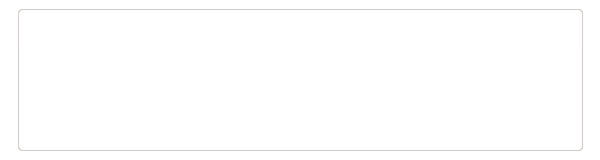
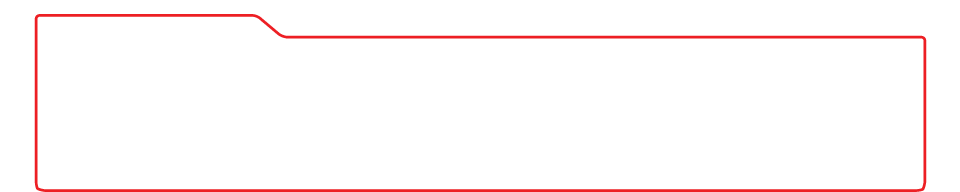
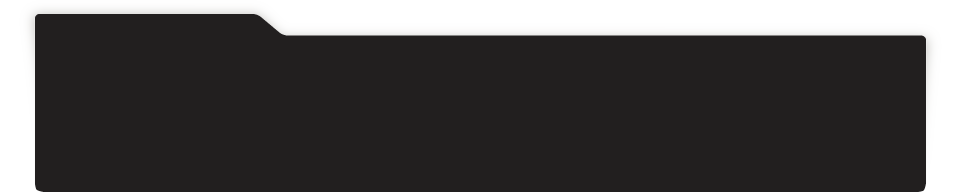
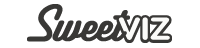
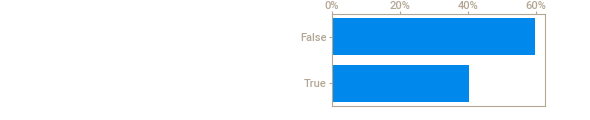
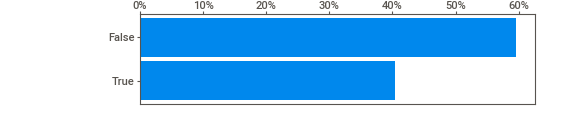
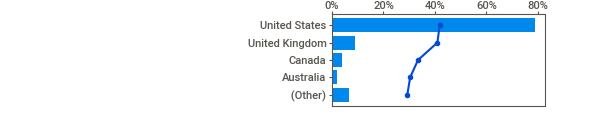
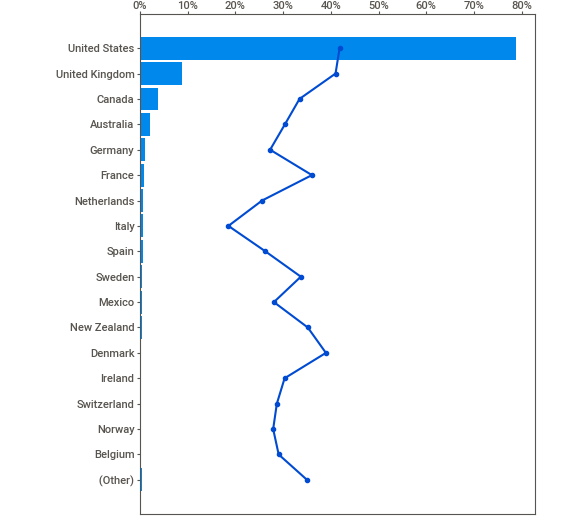
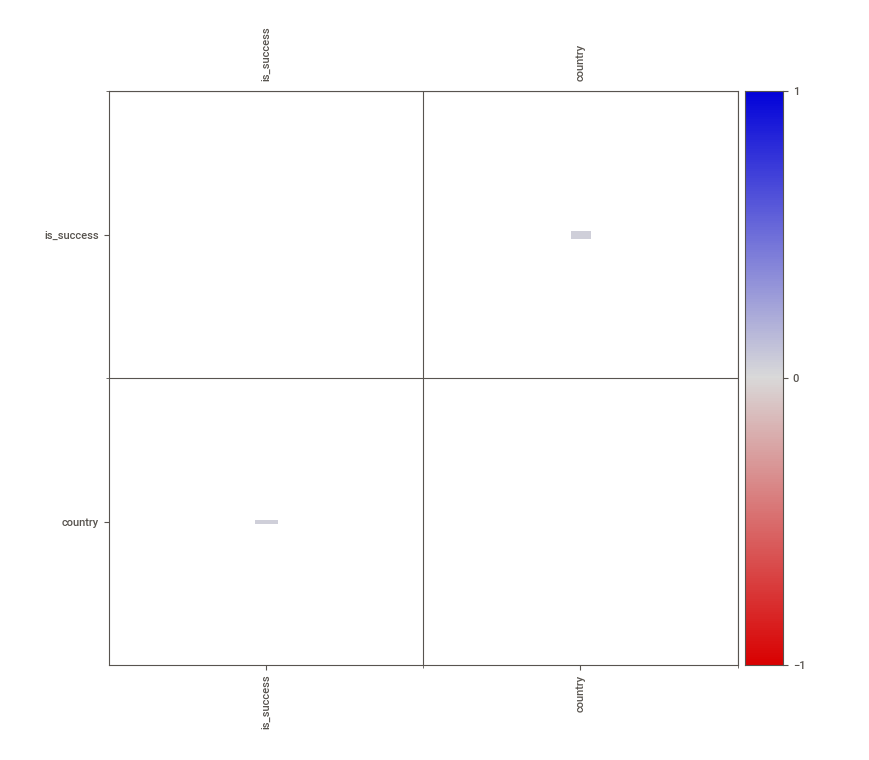
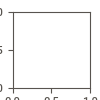

In [3]:
sv.analyze(DATA[["country", "is_success"]], target_feat="is_success").show_notebook()

In [4]:
SUCCESS_RATE_PER_COUNTRY = (
    DATA[["country", "is_success"]]
    # 国毎に成功PJ数と失敗PJ数を集計
    .groupby("country").apply(
        lambda x: (
            x.groupby("is_success").country.count()
            .to_dict()
        )
    )
    # 集計した成功・失敗PJ数から割合を計算
    .apply(
        lambda x: x.get(True, 0) / (x.get(False, 0) + x.get(True, 0))
    )
    # 列名
    .rename("success_rate")
)
SUCCESS_RATE_PER_COUNTRY


country
Australia              0.303731
Austria                0.220619
Belgium                0.290631
Canada                 0.334303
Denmark                0.389666
Euro Member            0.190476
France                 0.360317
Germany                0.272701
Hong Kong SAR China    0.452830
Ireland                0.303075
Italy                  0.185310
Japan                  0.304348
Luxembourg             0.333333
Mexico                 0.280652
Netherlands            0.255910
New Zealand            0.351648
Norway                 0.279110
Singapore              0.392070
Spain                  0.262680
Sweden                 0.337086
Switzerland            0.286810
United Kingdom         0.409859
United States          0.418258
Name: success_rate, dtype: float64

In [5]:
import pycountry
import warnings


def get_country_code(name: str):
    try:
        countries = pycountry.countries.search_fuzzy(name)
    except LookupError:
        warnings.warn(f"name={name} country not found")
        return None

    if len(countries) != 1:
        warnings.warn(
            f"""
        multiple countries hit
        name={name}
        hit={countries}
        """,
            UserWarning,
        )
    return countries[0].alpha_3


COUNTRY_CODE = (
    SUCCESS_RATE_PER_COUNTRY.index.to_series()
    .apply(get_country_code)
    .rename("country_code")
)
COUNTRY_CODE


/tmp/ipykernel_2067/2875002529.py:9: UserWarning:

name=Euro Member country not found

/tmp/ipykernel_2067/2875002529.py:9: UserWarning:

name=Hong Kong SAR China country not found

/tmp/ipykernel_2067/2875002529.py:13: UserWarning:


        multiple countries hit
        name=Ireland
        hit=[Country(alpha_2='IE', alpha_3='IRL', name='Ireland', numeric='372'), Country(alpha_2='GB', alpha_3='GBR', name='United Kingdom', numeric='826', official_name='United Kingdom of Great Britain and Northern Ireland'), Country(alpha_2='PG', alpha_3='PNG', name='Papua New Guinea', numeric='598', official_name='Independent State of Papua New Guinea')]
        

/tmp/ipykernel_2067/2875002529.py:13: UserWarning:


        multiple countries hit
        name=Luxembourg
        hit=[Country(alpha_2='LU', alpha_3='LUX', name='Luxembourg', numeric='442', official_name='Grand Duchy of Luxembourg'), Country(alpha_2='BE', alpha_3='BEL', name='Belgium', numeric='056', official_name='Kingdom of Belgium')]
 

country
Australia               AUS
Austria                 AUT
Belgium                 BEL
Canada                  CAN
Denmark                 DNK
Euro Member            None
France                  FRA
Germany                 DEU
Hong Kong SAR China    None
Ireland                 IRL
Italy                   ITA
Japan                   JPN
Luxembourg              LUX
Mexico                  MEX
Netherlands             NLD
New Zealand             NZL
Norway                  NOR
Singapore               SGP
Spain                   ESP
Sweden                  SWE
Switzerland             CHE
United Kingdom          GBR
United States           USA
Name: country_code, dtype: object

In [6]:
px.choropleth(
    pd.concat([SUCCESS_RATE_PER_COUNTRY, COUNTRY_CODE], axis=1).reset_index(),
    locations="country_code",
    color="success_rate",
    hover_name="country",
).show()
pd.concat([SUCCESS_RATE_PER_COUNTRY, COUNTRY_CODE], axis=1).reset_index()

,country,success_rate,country_code
0,Australia,0.303731,AUS
1,Austria,0.220619,AUT
2,Belgium,0.290631,BEL
3,Canada,0.334303,CAN
4,Denmark,0.389666,DNK
5,Euro Member,0.190476,None
6,France,0.360317,FRA
7,Germany,0.272701,DEU
8,Hong Kong SAR China,0.452830,None
9,Ireland,0.303075,IRL
